# Neural Network per IMPACT-US

## Packages

In [1]:
import sys
sys.path.insert(1, '../Machine_Learning')
sys.path.insert(2, '../')
import numpy as np
import pandas as pd
from datetime import datetime
import jupyprint.jupyprint as jp
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat

import shrimps_class

import matplotlib.pyplot as plt
from scipy.stats import  lognorm
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler

## Load dataset

In [2]:
file_mat = loadmat('../Machine_Learning/accidents.mat')

## Catalogazione dataset

In [3]:
data = np.delete(file_mat['hwydata'], 0, axis=1) # Elimina i dati della prima feature perché inutile

features = np.delete(file_mat['hwyheaders'], 0, axis=1) # Elimina l'etichetta della prima feature perché inutile

# data = file_mat['hwydata']
# features = file_mat['hwyheaders']

features = [i[0] for i in features[0]]

state_names = np.array([str(array[0][0]) for array in file_mat['statelabel']])

# Per rendere stati esterni casuali
#index = np.arange(51)
#np.random.shuffle(index)
#idx_ext = index[:10]
#idx_int = index[10:]

idx_ext = [2, 44, 39, 49, 27, 46, 40, 25, 21, 5]
idx_int = [42, 32, 18, 38, 37, 3, 8, 12, 34, 7, 24, 36, 22, 41, 
		   47, 28, 14, 23, 31, 33, 35, 19, 17, 10, 26, 9, 0, 
		   6, 45, 15, 1, 43, 48, 11, 20, 16, 50, 30, 13, 29, 4]

data_ext = data[idx_ext]
data_int = data[idx_int]

state_names_ext = state_names[idx_ext]
state_names_int = state_names[idx_int]

# print('Samples:', state_names.tolist())
# print('Samples_int:', state_names_int)
# print('Samples_ext:', state_names_ext)
# print('Features:', features)


density_int = [data_int[:,features.index('Traffic fatalities')] * 100000 / data_int[:,features.index('Total Population')],
			   data_int[:,features.index('Fatalities per 100K licensed drivers')],
			   data_int[:,features.index('Fatalities per 100K registered vehicles')]
			  ]

density_ext = [data_ext[:,features.index('Traffic fatalities')] * 100000 / data_ext[:,features.index('Total Population')],
			   data_ext[:,features.index('Fatalities per 100K licensed drivers')],
			   data_ext[:,features.index('Fatalities per 100K registered vehicles')]
			  ]

# jupyprint(pd.DataFrame(data, index = [str(array[0][0]) for array in file_mat['statelabel']], columns = features ))

## Prova fit con lognorm

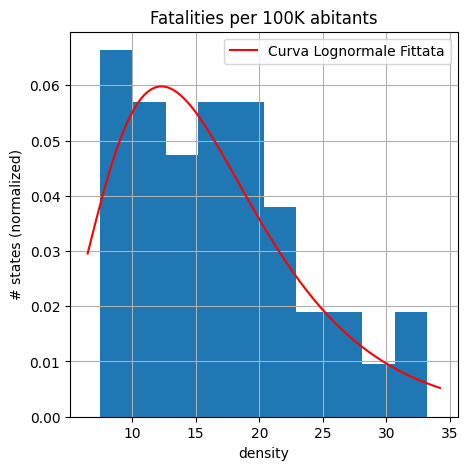

In [4]:
density = density_int[0]

frequencies, bin_edges = np.histogram(density, bins=10)  # Modifica il numero di bin se necessario

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # punti medi dei bin

# Definisci la funzione lognormale da fittare ai dati
def lognorm_func(x, sigma, loc, scale):
	return frequencies.sum() * np.diff(bin_edges)[0] * lognorm.pdf(x, sigma, loc=loc, scale=scale)  # Il termine seguente "frequencies.sum() * np.diff(bin_edges)[0]" corrisponde all'area dell'istogramma, serve per riscalare la pdf in modo da fittarla con i nostri dati

# Fittare la curva ai dati
popt, pcov = curve_fit(lognorm_func, bin_centers, frequencies)

# Parametri ottimizzati
sigma_fit, loc_fit, scale_fit = popt

# Crea una distribuzione lognormale con i parametri fittati
x = np.linspace(min(density)-1, max(density)+1, 100)
pdf_fit = lognorm.pdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)

# Plot dei dati e della curva fittata
plt.figure(figsize=(5, 5))

plt.subplot()

plt.hist(density, density=True)
plt.plot(x, pdf_fit, 'r-', label='Curva Lognormale Fittata')
plt.legend()
plt.grid()
plt.xlabel('density')
plt.ylabel('# states (normalized)')
plt.title('Fatalities per 100K abitants')
plt.show()

In [5]:
# Calcolo della seconda derivata
def second_derivative(func, x):
	h = 0.0001
	return (func(x - 2*h) - 2 * func(x - h) + func(x)) / (h ** 2)

# Calcolo dei punti in cui la concavità cambia
x_values = np.linspace(int(min(density_int[0])), int(max(density_int[0])),)  # range di valori di x da esaminare
second_derivatives = second_derivative(lambda x: lognorm_func(x, sigma_fit, loc_fit, scale_fit), x_values)
sign_changes = np.where(np.diff(np.sign(second_derivatives)))

# Stampa dei punti in cui la concavità cambia
print("Punti in cui la concavità cambia:")
for index in sign_changes:
	print("x =", x_values[index])

Punti in cui la concavità cambia:
x = [18.14285714]


## Creazione label e rimozione delle feature usate per determinare il cutoff

In [6]:
# Soglia densità per 100k abitanti (a sentimento(cambio segno derivata seconda))
cutoff = x_values[sign_changes[0][-1]]

labels_int = np.zeros(len(density_int[0]))
labels_int[density_int[0] > cutoff] = 1

labels_ext = np.zeros(len(density_ext[0]))
labels_ext[density_ext[0] > cutoff] = 1

# data_int = np.delete(data_int, features.index('Fatalities per 100K registered vehicles'), axis=1) # Elimina i dati degli incidenti perchè usati per la label
# data_ext = np.delete(data_ext, features.index('Fatalities per 100K registered vehicles'), axis=1) #
# del features[features.index('Fatalities per 100K registered vehicles')]                           #

data_int = np.delete(data_int, features.index('Traffic fatalities'), axis=1) # Elimina i dati degli incidenti perchè usati per la label
data_ext = np.delete(data_ext, features.index('Traffic fatalities'), axis=1) #
del features[features.index('Traffic fatalities')]                           #

data_int = np.delete(data_int, features.index('Total Population'), axis=1) # Elimina i dati della popolazione totale perchè usati per la label
data_ext = np.delete(data_ext, features.index('Total Population'), axis=1) #
del features[features.index('Total Population')]                           #


scaler = StandardScaler()
data_int = scaler.fit_transform(data_int)
data_ext = scaler.fit_transform(data_ext)

## PCA 

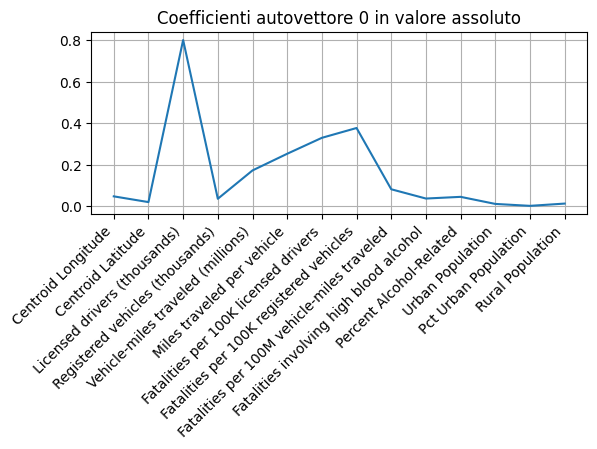

In [7]:
PCA = shrimps_class.PCA_Class(data_int, data_ext, features)
cov_mat = PCA.get_cov_mat(show_tb = False)
eval    = PCA.get_eval(show_tb = False)
evec    = PCA.get_evec(show_tb = False)

# PCA.show_eval_percent()

t = 0.96

PCA_data    	= PCA.get_PCA_data(t, show_tb = False)
PCA_data_int 	= PCA_data['pca_data_int']
PCA_data_ext 	= PCA_data['pca_data_ext']

PCA.show_evec(0)

# Rete singola

## Training

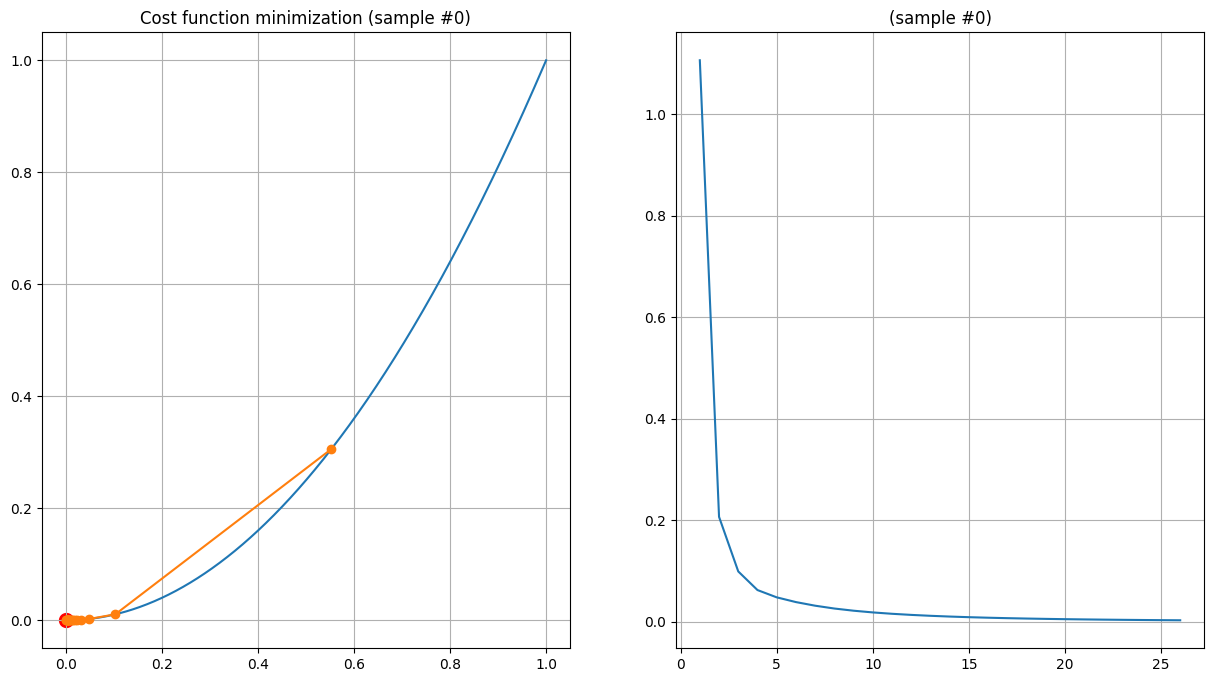

In [8]:
weights         = 2 * np.random.rand(len(data_int[0])) - 1                # crea una matrice 1x3 con numeri casuali tra -1 e 1
correct_outputs = labels_int               
epochs          = 25
inputs         	= data_int
LR              = 0.1

NN = shrimps_class.NN_Class()

results = NN.training(weights, inputs, correct_outputs, epochs, LR)
NN.plt_epochs(results = results, idx_sample = 0)

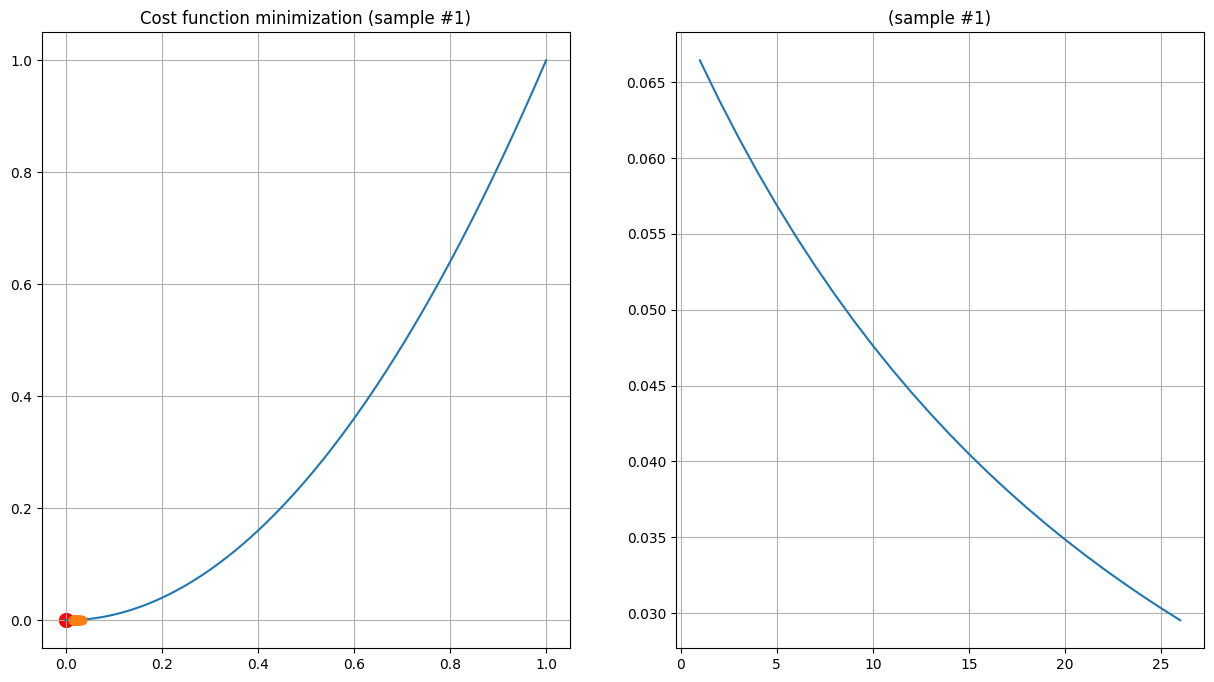

In [9]:
# Per allenare ulteriormente
results = NN.training(weights, inputs, correct_outputs, epochs, LR)
NN.plt_epochs(results = results, idx_sample = 1)

## Testing interno

In [10]:
weights          = results['container_weights'][-1]
correct_outputs  = results['correct_outputs']
epochs           = results['epochs']
inputs           = results['inputs']

accuracy    = 0
sensitivity = 0
specificity = 0
FP          = 0
FN          = 0


# Ciclo sui 4 vettori di input
for k in range(len(inputs)):                       
	weighted_sum = weights @ inputs[k]  # Prodotto scalare tra pesi allenati e input
	predicted = NN.Sigmoid(weighted_sum)

	# Caso 0 -> Negative
	if correct_outputs[k] == 0 and predicted < 0.5:
		accuracy += 1 / len(correct_outputs)
		specificity += 1 / (len(correct_outputs)-np.sum(correct_outputs))

	# Caso 1 -> Positive
	if correct_outputs[k] == 1 and predicted >= 0.5:
		accuracy += 1 / len(correct_outputs)
		sensitivity += 1 / np.sum(correct_outputs)

	# Caso 1 -> Negative
	if correct_outputs[k] == 1 and predicted < 0.5:
		FN += 1 / np.sum(correct_outputs)

	# Caso 0 -> Positive
	if correct_outputs[k] == 0 and predicted >= 0.5:
		FP += 1 / (len(correct_outputs)-np.sum(correct_outputs))

print('Accuracy    : ', accuracy)
print('Sensitivity : ', sensitivity)
print('Specificity : ', specificity)
print('FN          : ', FN)
print('FP          : ', FP)


Accuracy    :  1.0000000000000004
Sensitivity :  1.0
Specificity :  0.9999999999999996
FN          :  0
FP          :  0


## Testing esterno

In [11]:
weights          = results['container_weights'][-1]
correct_outputs  = results['correct_outputs']
epochs           = results['epochs']
inputs           = results['inputs']

accuracy    = 0
sensitivity = 0
specificity = 0
FP          = 0
FN          = 0


# Ciclo sui 4 vettori di input
for k in range(len(data_ext)):                       
	weighted_sum = weights @ data_ext[k]  # Prodotto scalare tra pesi allenati e input
	predicted = NN.Sigmoid(weighted_sum)

	# Caso 0 -> Negative
	if labels_ext[k] == 0 and predicted < 0.5:
		accuracy += 1 / len(labels_ext)
		specificity += 1 / (len(labels_ext)-np.sum(labels_ext))

	# Caso 1 -> Positive
	if labels_ext[k] == 1 and predicted >= 0.5:
		accuracy += 1 / len(labels_ext)
		sensitivity += 1 / np.sum(labels_ext)

	# Caso 1 -> Negative
	if labels_ext[k] == 1 and predicted < 0.5:
		FN += 1 / np.sum(labels_ext)

	# Caso 0 -> Positive
	if labels_ext[k] == 0 and predicted >= 0.5:
		FP += 1 / (len(labels_ext)-np.sum(labels_ext))

print('Accuracy    : ', accuracy)
print('Sensitivity : ', sensitivity)
print('Specificity : ', specificity)
print('FN          : ', FN)
print('FP          : ', FP)

Accuracy    :  0.7999999999999999
Sensitivity :  1.0
Specificity :  0.7142857142857142
FN          :  0
FP          :  0.2857142857142857


# K reti

In [12]:
pd.options.display.float_format = None

K = 4

weight          = 2 * np.random.rand(len(data_int[0])) - 1
weights         = np.ones((K, len(data_int[0]))) * weight
correct_outputs = labels_int               
epochs          = 25
inputs         	= data_int
LR              = 0.1

N = len(labels_int)

original_indices = np.arange(N)

fd = NN.data_folding(K, N)

K, index = fd

accuracy = np.zeros(4)
sensitivity = np.zeros(4)
specificity = np.zeros(4)
FN = np.zeros(4)
FP = np.zeros(4)

for ind in range(K):
	temp_train_set = np.ones(data_int.shape[0], dtype=bool)

	temp_train_set[index == ind] = False
	temp_test_set = ~temp_train_set
	
	temp_train_indices = original_indices[temp_train_set]
	temp_test_indices = original_indices[temp_test_set]
	
	temp_train_labels = labels_int[temp_train_indices]
	temp_test_labels = labels_int[temp_test_indices]
	
	temp_train_data = data_int[temp_train_indices, :]
	temp_test_data = data_int[temp_test_indices, :]
	
	try:
		pc_tr_data = np.squeeze(temp_train_data)
		
		results = NN.training(weights[ind,:], pc_tr_data, temp_train_labels, epochs, LR)
		weights[ind, :] = results['container_weights'][-1]
		
	except Exception as e:
		print('Error optimization preprocessing')
		msgString = str(e)
	
	# TESTING phase
	temp_te_data = np.squeeze(temp_test_data)
	
	prob_pred_fold = np.zeros(temp_te_data.shape[0])
	
	for subject in range(temp_te_data.shape[0]):
	
		pc_temp_tdata = temp_te_data[subject, :]
		
		temp_tlabel = temp_test_labels[subject]
		
		if pc_temp_tdata.shape[0] == 0:
				print('No data!')
		
		else:
			# Label predetta dal modello
			weighted_sum = weights[ind,:] @ pc_temp_tdata  # Prodotto scalare tra pesi allenati e input
			class_pred = NN.Sigmoid(weighted_sum)
			
			# Caso 0 -> Negative
			if temp_tlabel == 0 and class_pred < 0.5:
				accuracy[ind] += 1 / temp_test_labels.shape[0]
				specificity[ind] += 1 / (temp_test_labels.shape[0]-np.sum(temp_test_labels))
			
			# Caso 1 -> Positive
			if temp_tlabel == 1 and class_pred >= 0.5:
				accuracy[ind] += 1 / temp_test_labels.shape[0]
				sensitivity[ind] += 1 / np.sum(temp_test_labels)
			
			# Caso 1 -> Negative
			if temp_tlabel == 1 and class_pred < 0.5:
				FN[ind] += 1 / np.sum(temp_test_labels)
			
			# Caso 0 -> Positive
			if temp_tlabel == 0 and class_pred >= 0.5:
				FP[ind] += 1 / (temp_test_labels.shape[0]-np.sum(temp_test_labels))

	print('K = ', ind)
	print('Accuracy    : ', accuracy[ind])
	print('Sensitivity : ', sensitivity[ind])
	print('Specificity : ', specificity[ind])
	print('FN          : ', FN[ind])
	print('FP          : ', FP[ind], '\n')


K =  0
Accuracy    :  0.9090909090909093
Sensitivity :  0.9999999999999999
Specificity :  0.8
FN          :  0.0
FP          :  0.2 

K =  1
Accuracy    :  0.7999999999999999
Sensitivity :  1.0
Specificity :  0.7142857142857142
FN          :  0.0
FP          :  0.2857142857142857 

K =  2
Accuracy    :  0.7999999999999999
Sensitivity :  0.6666666666666666
Specificity :  0.857142857142857
FN          :  0.3333333333333333
FP          :  0.14285714285714285 

K =  3
Accuracy    :  0.9999999999999999
Sensitivity :  1.0
Specificity :  1.0
FN          :  0.0
FP          :  0.0 



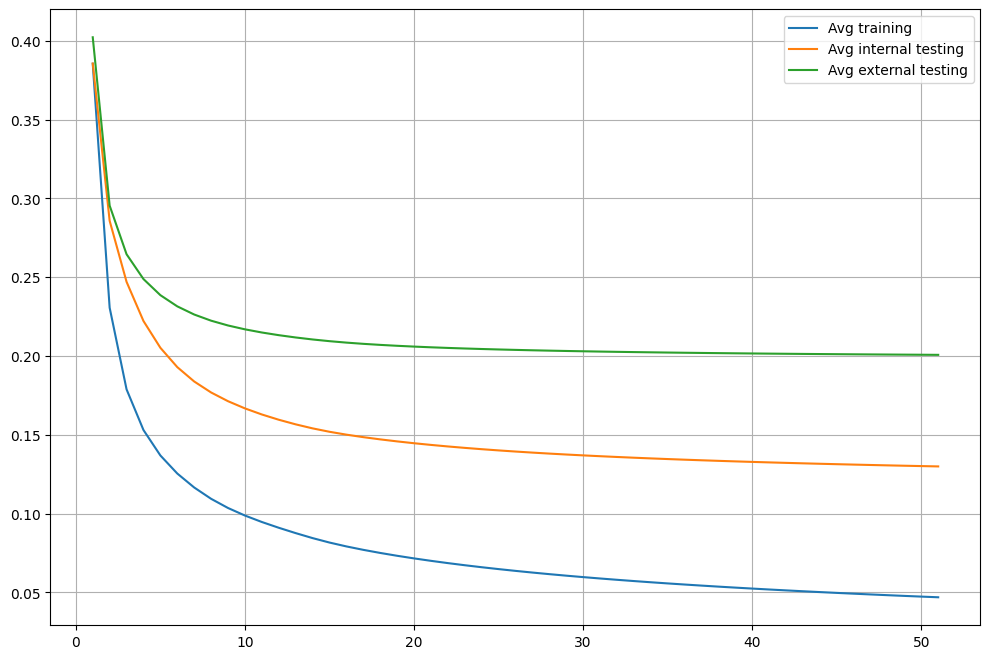

In [23]:
pd.options.display.float_format = None

K = 6
weights         = 2 * np.random.rand(K, len(data_int[0])) - 1
correct_outputs = labels_int
epochs        	= 50
inputs         	= data_int
LR              = 0.1

results_tr = np.zeros(K, dtype = object)
results_te = np.zeros(K, dtype = object)
results_ext_te = np.zeros(K, dtype = object)
P_ext = np.zeros((len(data_ext), epochs + 1), dtype = object)
avg_tr = np.zeros(epochs + 1)
avg_te = np.zeros(epochs + 1)

N = len(labels_int)
original_indices = np.arange(N)

indices = NN.data_folding(K, N)[1]


for ind in range(K):
	bool_train_set 					= np.ones(data_int.shape[0], dtype=bool)

	# Training data
	bool_train_set[indices == ind] 	= False
	train_indices 					= original_indices[bool_train_set]
	train_labels 					= labels_int[train_indices]
	train_data 						= data_int[train_indices, :]
	
	# Testing data
	bool_test_set 					= ~bool_train_set
	test_indices 					= original_indices[bool_test_set]
	test_labels 					= labels_int[test_indices]	
	test_data 						= data_int[test_indices, :]
	

	# TRAINING phase
	sq_tr_data = np.squeeze(train_data)
	results_tr[ind] = NN.training(
								weights 		= weights[ind, :], 
							   	inputs 			= sq_tr_data, 
							   	correct_outputs = train_labels, 
							   	epochs 			= epochs, 
							   	LR 				= LR
								)
	
	P = results_tr[ind]['P']
	E = results_tr[ind]['E']
	avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	



	# TESTING phase
	results_te[ind] = NN.trend_over_epochs(
										inputs = test_data, 
										correct_outputs = test_labels, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P = results_te[ind]['P']
	E = results_te[ind]['E']
	avg_te += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	

	# TESTING esterno

	results_ext_te[ind] = NN.trend_over_epochs(
										inputs = data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P_ext += results_ext_te[ind]['P'] / K


# P = results_ext_te['P']
E = results_ext_te[0]['E']
avg_ext_te = np.sum(np.abs(P_ext - E), axis = 0) / len(P_ext[:, 0])



c_w = results_tr[1]['container_weights']
# P = results_tr[1]['P'][0]
# E = results_tr[1]['E'][0]

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_te, label = 'Avg internal testing')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# c_w = results_tr[0]['container_weights']

# plt.figure(figsize=(12, 8))
# # P_tr_avg = np.sum(results_tr[0]['P'], axis = 0) / len(results_tr[0]['P'])
# # E_tr_avg = np.sum(results_tr[0]['E'], axis = 0) / len(results_tr[0]['E'])										  
# plt.plot(np.arange(1, len(c_w)+1), 2*(P_tr_avg - E_tr_avg), label = 'Avg Trained')
# # plt.plot(np.arange(1, len(c_w)+1), 2*(P_te_avg - E_te_avg), label = 'Avg Tested')
# plt.legend()
# plt.show()




# plt.figure(figsize=(15, 8))

# for i in range(1, K + 1):
# 	plt.subplot(3, 2, i)
# 	x = np.arange(epochs)  
# 	plt.grid()
# 	plt.plot(x, accuracy[:,i-1], label='accuracy')
# 	plt.plot(x, sensitivity[:,i-1], label='sensitivity')
# 	plt.plot(x, specificity[:,i-1], label='specificity')
# 	plt.plot(x, FN[:,i-1], label='FN')
# 	plt.plot(x, FP[:,i-1], label='FP')
# 	plt.title('metrics, K = ' + str(i))
# 	plt.legend()

# plt.show()